# Table of Contents

[Notebook Workflow Step-by-Step for CTX](#notebook-workflow-step-by-step-for-ctx)

[Setup variables and configs](#setup-variables-and-configs)

1. [1. Download images](#1-download-images)
    - [Preview left and right image](#preview-left-and-right-image)
2. [2. First Step of CTX processing lev1eo](#2-first-step-of-ctx-processing-lev1eo)
3. [3. Metadata init](#3-metadata-init)
    - [3.1. Stereo Quality Report](#31-stereo-quality-report)
    - [Downsample images if requested](#downsample-images-if-requested)
4. [4. Bundle adjustment](#4-bundle-adjustment)
5. [5. Stereo first run (steps 1-3 of stereo in ASP)](#5-stereo-first-run-steps-1-3-of-stereo-in-asp)
6. [6. Stereo first run (step 4 of stereo in ASP)](#6-stereo-first-run-step-4-of-stereo-in-asp)
7. [7. Produce low resolution DEM for map projection](#7-produce-low-resolution-dem-for-map-projection)
8. [8. Make GoodPixelMap and Hillshade Previews](#8-make-goodpixelmap-and-hillshade-previews)
    - [Good Pixel Map](#good-pixel-map)
    - [Hillshade of low res DEM](#hillshade-of-low-res-dem)
9. [9. Mapproject ctx against 100m DEM](#9-mapproject-ctx-against-100m-dem)
10. [10. Calculate Better DEM using prior](#10-calculate-better-dem-using-prior)
11. [11. PC alignment (Step 5)](#11-pc-alignment-step-5)
    - [Good Pixel Preview](#good-pixel-preview)
    - [Hillshade of higher res DEM](#hillshade-of-higher-res-dem)
    - [Show pedr data](#show-pedr-data)
12. [12. Start of PC align portion](#12-start-of-pc-align-portion)


# Notebook Workflow Step-by-Step for CTX

Now that we have run the Jupyter Notebook based workflows through the command line interface, we can look at each step that was run and describe what happened in more detail. Note that the function docstrings are also available to describe the parameters of a given step, and what that step does. Below is an export of all the codeblocks in the notebook workflow, additional markdown cells are included in the files but are not important to reproduce here. This workflow replicates the same workflow used by the asp_scripts project.

First define all the parameters for the notebook for papermill. The notebook includes a cell metadata tag for papermill to allow these parameters to be defined at runtime. First we need the left and right image ids, the left image typically has the lower emission angle. ASAP will check the metadata of the images to ensure the correct order is provided. The config1 and config2 parameters are paths to stereo.default files the user has to configure the Ames Stereo Pipeline. The first config file is the only required parameter, config2 gives you to use higher quality parameters for the 2nd pass CTX DEM. The “dem_gsd” and “img_gsd” parameters control the number of pixels per pixel the final DEM and orthorectified images have. These default to 24 and 6 meters per pixel which works for generally any CTX image pair. Generally, most CTX images are captured at around 5.5 meters per pixel (GSD) so we pick 6 mpp as a reasonable default. By convention, the DEM post spacing should be at least 3X the image GSD. ASAP defaults to 4X the image GSD to be a bit more conservative, resulting in 24 meters per pixel. Output_path is typically left blank to default to the current working directory. The maxdisp parameter controls the maximum expected disparity (distance) between the intermediate CTX DEM and the reference topography. Leaving this as ‘None’ will allow ASAP to estimate the disparity for you. The downsample parameter allows you to downsample the imagery by a factor of the value to reduce processing times, a downsample of 4 will reduce the number of pixels by a factor of 4. The pedr_list variable points to the local copy of a file containing a list of all the paths to all of the MOLA PEDR data. By default this is set to None to use the ODE REST API to grab the necessary PEDR data, which is much faster anyways.


# Setup variables and configs

In [1]:
from src.asp_wrapper import CommonSteps
%load_ext autoreload
%autoreload 2

In [2]:
left  = 'G03_019456_1646'
right = 'G04_019601_1646'

# left = 'P02_001981_1823'
# right = 'P03_002258_1817'


config1 = None
config2 = None
dem_gsd  = 24.0
img_gsd  = 6.0
output_path = None
max_disp = None
downsample = None
refdem = None
step_kwargs = {}
# todo: add reference_dem and use to conditional pedr things

`if config2 == None:`
`    config2 = config1`

`!cat {config1}`

`!cat {config2}`


In [3]:
from IPython.display import Image
from pathlib import Path
from src.ctx import CTX
from src.moody import ODE
import math
import os

default_output_dir = os.path.join(os.getcwd(), 'output')

# Initialize the ODE and CTX classes
ctx = CTX()
ode = ODE(https=True)

# Reassign left and right to the correct order
left, right = ctx.get_ctx_order(left, right)

output_path = os.path.join(default_output_dir, f'a_{left}_{right}/') if not output_path else output_path
print("Output directory: ", output_path)

if not os.path.exists(output_path):
    os.makedirs(output_path)

print("Left image PID:  %s\nRight image PID: %s" % (left, right))

Output directory:  /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_G03_019456_1646_G04_019601_1646/
Left image PID:  G03_019456_1646
Right image PID: G04_019601_1646


# 1. Download images


Now we are getting to the heart of the notebook workflow. First use step-one to download our left and right images using the moody tool. At the end of the command you can see we are using standard bash to redirect stdout and stderr to two log files, the first a log just for this step, the second a cumulative log file for the whole job.

`asap ctx step_1 {left} {right} 2>&1 | tee -i -a ./1_download.log ./full_log.log`


In [4]:
# ctx.step_1()
# ctx.generate_ctx_pair_list(left, right)
left_id = ctx.get_full_ctx_id(left)
right_id = ctx.get_full_ctx_id(right)
# download files
left_path = ode.download_ctx_edr(left_id, output_path)
right_path = ode.download_ctx_edr(right_id, output_path)

## Preview left and right image

In [7]:
# left_tiff = os.path.join(os.path.dirname(left_path), f'{left_id}.tif')
# right_tiff = os.path.join(os.path.dirname(right_path), f'{right_id}.tif')

left_stem = os.path.join(os.path.dirname(left_path), f'{left_id}')
right_stem = os.path.join(os.path.dirname(right_path), f'{right_id}')

!gdal_translate -of GTiff {left_path} {left_stem}.tif
!gdal_translate -of GTiff {right_path} {right_stem}.tif

!gdal_translate -of PNG {left_path} {left_stem}.png
!gdal_translate -of PNG {right_path} {right_stem}.png

Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.


/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


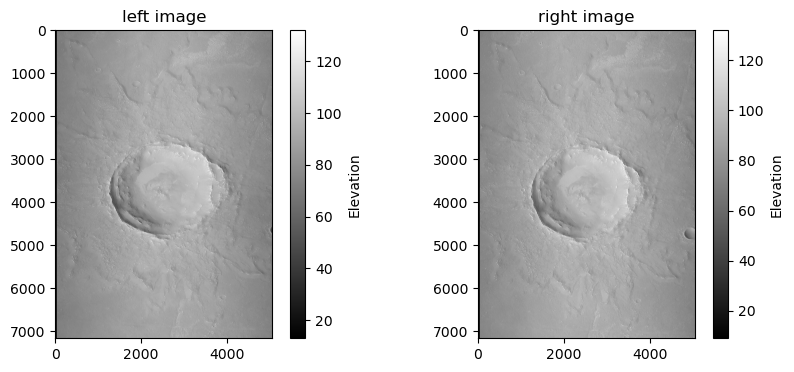

In [6]:
import matplotlib.pyplot as plt
import rasterio

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

with rasterio.open(f'{left_stem}.tif', 'r') as src:
    img = ax1.imshow(src.read(1), cmap='gray')
    plt.colorbar(img, ax=ax1, label='Elevation')
    ax1.set_title('left image')

with rasterio.open(f'{right_stem}.tif', 'r') as src:
    img = ax2.imshow(src.read(1), cmap='gray')
    plt.colorbar(img, ax=ax2, label='Elevation')
    ax2.set_title('right image')

plt.show()

# 2. First Step of CTX processing lev1eo

Now we replicate the preprocessing from the asp_scripts project/ames stereo pipeline using ISIS commands. This step will run these steps in the following order:

1) `mroctx2isis`
2) `spiceinit`
3) `spicefit`
4) `ctxcal`
5) `ctxevenodd`

`$ asap ctx step_2 {asap.kwarg_parse(step_kwargs, 'step_2')} 2>&1 | tee -i -a ./2_ctxedr2lev1eo.log ./full_log.log`

Для корректной работы команд необходимо предзагрузить IsisData отсюда: https://astrogeology.usgs.gov/docs/how-to-guides/environment-setup-and-maintenance/isis-data-area/

Т.к. работаем с миссей Mars Reconnaissance Orbiter, нужно ввести `downloadIsisData mro $ISISDATA`

In [21]:
from src.utils.common import par_do, rich_logger


# @rich_logger
# def step_2(ctx_wrapper: CTX, with_web=False):
#     """
#     ISIS3 CTX preprocessing, replaces ctxedr2lev1eo.sh
#
#     :param with_web: if true attempt to use webservices for SPICE kernel data
#     """

par_do(ctx.cs.mroctx2isis, [f'from={i}.IMG to={i}.cub' for i in [left_stem, right_stem]],)

cubs = list(Path(output_path).glob('*.cub'))

par_do(ctx.cs.spiceinit, [f'from={str(c)} web=yes' for c in cubs])

par_do(ctx.cs.spicefit, [f'from={str(c)}' for c in cubs])
#
par_do(ctx.cs.ctxcal, [f'from={str(c)} to={str(c.parent)}/{c.stem}.lev1.cub' for c in cubs])
for cub in cubs:
    cub.unlink()

"""
**USER ERROR** The CTX image [/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N13_067270_0910_XN_89S005W.lev1.cub] has already been radiometrically calibrated.
"""
# lev1cubs = list(Path(output_path).glob('*.lev1.cub'))

# par_do(ctx.cs.ctxevenodd, [f'from={str(c)} to={str(c.parent)}/{c.stem}.eo.cub' for c in lev1cubs])
# for lc in lev1cubs:
#     lc.unlink()


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/mroctx2isis from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N13_067270_0910_XN_89S005W.IMG to=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N13_067270_0910_XN_89S005W.cub: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/mroctx2isis from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N12_067124_0910_XN_89S006W.IMG to=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N12_067124_0910_XN_89S006W.cub: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/spiceinit from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N12_067124_0910_XN_89S006W.cub web=yes: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/sp

'\n**USER ERROR** The CTX image [/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N13_067270_0910_XN_89S005W.lev1.cub] has already been radiometrically calibrated.\n'

In [24]:
!ls {output_path}

N12_067124_0910_XN_89S006W.IMG	     N13_067270_0910_XN_89S005W.IMG
N12_067124_0910_XN_89S006W.lev1.cub  N13_067270_0910_XN_89S005W.lev1.cub
N12_067124_0910_XN_89S006W.tif	     N13_067270_0910_XN_89S005W.tif


![](../screenshots/qview_895005W.lev1.cub.png)

In [17]:
test = list(Path(output_path).glob('*.cub'))[0]
str(test)

'/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N12_067124_0910_XN_89S006W.cub'

# 3. Metadata init

Now we create a number of metadata files used by the asp_scripts project to simplify future command calls. We also copy our preprocessed CTX cub files into a new working directory where all the stereo products will be computed. This new directory name uses both image IDs joined by an underscore ‘{left_id}_{right_id}’, for example: “B03_010644_1889_XN_08N001W_P02_001902_1889_XI_08N001W”.

`$ asap ctx step_3`

In [ ]:
"""
        Create various processing files for future steps
        # todo: deduplicate with hirise side
        """
ctx.cs.create_stereopairs_lis()
ctx.cs.create_stereodirs_lis()
ctx.cs.create_stereodirs()
ctx.cs.create_stereopair_lis()
# copy the cub files into the both directory
_, _, both = self.cs.parse_stereopairs()
# sh.mv('-n', sh.glob('./*.cub'), f'./{both}/') # Rewrite with !

## 3.1. Stereo Quality Report

In [ ]:
qual_report = CommonSteps().get_stereo_quality_report(f'{left}_{right}/{left}.lev1eo.cub', f'{left}_{right}/{right}.lev1eo.cub')
print(qual_report)

### Downsample images if requested

In [ ]:
if downsample:
    true_img_gsd_left = CommonSteps().get_image_gsd(f'{left}_{right}/{left}.lev1eo.cub')
    true_img_gsd_right = CommonSteps().get_image_gsd(f'{left}_{right}/{right}.lev1eo.cub')
    # take conservative approach, pick worst image GSD
    res_gsd = max(true_img_gsd_left, true_img_gsd_right)
    # this is because rescale in ISIS does not update GSD in metadata
    CommonSteps().rescale_and_overwrite(factor=downsample)
    img_gsd = math.ceil(res_gsd)*downsample
    dem_gsd = 4*img_gsd
    print('new img gsd', img_gsd)
    print('new dem gsd', dem_gsd)

# 4. Bundle adjustment

We will use the parallel_bundle_adjust command from Ames Stereo Pipeline to refine the spacecraft position and orientation. The user can later re-run this step with more advanced options or GCPs if so desired.

`!asap ctx step_4 {asap.kwarg_parse(step_kwargs, 'step_4')} 2>&1 | tee -i -a ./2_bundle_adjust.log ./full_log.log`

In [ ]:
"""
Bundle Adjust CTX

Run bundle adjustment on the CTX map projected data

:param vargs: variable length additional positional arguments to pass to bundle adjust
:param bundle_adjust_prefix: prefix for bundle adjust output
:param postfix: postfix for cub files to use
:param camera_postfix: postfix for cameras
"""
# ctx.cs.bundle_adjust(*vargs, postfix=postfix, camera_postfix=camera_postfix,
#                              bundle_adjust_prefix=bundle_adjust_prefix, **kwargs)

# 5. Stereo first run (steps 1-3 of stereo in ASP)

Now we can start making our first dem, we pass in the stereo config file to parallel_stereo. We split this into two parts (step 5 & 6) as we may want to run each part with slightly different parameters or give us a chance to inspect the outputs before the final step which can be long running. In the future Step 5 & & maybe reconfigured into the 4 sub-steps for further improvement to the workflow.

`!asap ctx step_5 {config1} {asap.kwarg_parse(step_kwargs, 'step_5')} 2>&1 | tee -i -a ./3_lev1eo2dem.log ./full_log.log`

In [ ]:
"""
Parallel Stereo Part 1

Run first part of parallel_stereo asp_ctx_lev1eo2dem.sh

:param postfix: postfix for cub files to use
:param camera_postfix: postfix for cameras  # TODO: use .adjusted_state.json?
"""
# return self.cs.stereo_asap(stereo_conf, postfix=postfix, camera_postfix=camera_postfix,
#                            posargs=posargs, **{**self.cs.defaults_ps1, **kwargs})

# 6. Stereo first run (step 4 of stereo in ASP)

Run step 4, see step 5 above for more information.

`!asap ctx step_6 {config1} {asap.kwarg_parse(step_kwargs, 'step_6')}  2>&1 | tee -i -a ./3_lev1eo2dem.log ./full_log.log`

In [ ]:
"""
Parallel Stereo Part 2

Run second part of parallel_stereo, asp_ctx_lev1eo2dem.sh stereo is completed after this step

:param postfix: postfix for cub files to use
:param camera_postfix: postfix for cameras  # TODO: use .adjusted_state.json?
"""
# return self.cs.stereo_asap(stereo_conf, postfix=postfix, camera_postfix=camera_postfix,
#                            posargs=posargs, **{**self.cs.defaults_ps2, **kwargs})

# 7. Produce low resolution DEM for map projection

We have made a point cloud, but it is preliminary so we will use it to make a 100 mpp DEM to map-project the CTX images to, to produce a better 2nd pass DEM.


`! asap ctx step_7 --mpp 100 --just_ortho False --dem_hole_fill_len 50 {asap.kwarg_parse(step_kwargs, 'step_7')} 2>&1 | tee -i -a ./4_make_100m_dem.log ./full_log.log`

In [7]:
"""
Produce preview DEMs/Orthos

Produce dem from point cloud, by default 24mpp for ctx for max-disparity estimation

:param run: folder for results
:param just_ortho: set to True if you only want the ortho image, else make dem and error image
:param mpp: resolution in meters per pixel
:param postfix: postfix for cub files to use
"""
mpp = 100
just_ortho = False
dem_hole_fill_len = 50

# return self.cs.point_to_dem(mpp, 'PC.tif',
#                             just_ortho=just_ortho,
#                             postfix=postfix,
#                             run=run,
#                             kind='ba',
#                             use_proj=self.proj,
#                             **kwargs)
ctx.cs.point_to_dem(mpp, 'PC.tif', just_ortho=just_ortho)

# 8. Make GoodPixelMap and Hillshade Previews
We make image previews of the DEM using the next few steps to check for issues with our first pass DEM. First we will render out the good pixel map image and then the hillshade of the DEM to look for issues with the topography.

`!asap ctx step-8`

In [ ]:
"""
hillshade First step in asp_ctx_step2_map2dem script

:param output_folder:
:param run:
"""
left, right, both = ctx.cs.parse_stereopairs()
with cd(Path.cwd() / both / run / output_folder):
    dem = next(Path.cwd().glob('*DEM.tif'))
    self.cs.hillshade(dem.name, f'./{dem.stem}-hillshade.tif')

## Good Pixel Map 

In [ ]:
both = f'{left}_{right}'
img = f'./{both}/results_ba/{both}_ba-GoodPixelMap.tif'
out = img.replace('.tif', '.png')

In [ ]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

In [ ]:
Image(filename=out, width=800)

## Hillshade of low res DEM

In [ ]:
both = f'{left}_{right}'
img = f'./{both}/results_ba/dem/{both}_ba_100_0-DEM-hillshade.tif'
out = img.replace('.tif', '.png')

In [ ]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

In [ ]:
Image(filename=out, width=800)

# 9. Mapproject ctx against 100m DEM

`!asap ctx step_9 --mpp {img_gsd} {asap.kwarg_parse(step_kwargs, 'step_9')} 2>&1 | tee -i -a ./5_mapproject_to_100m_dem.log ./full_log.log`

In [ ]:
""""
Mapproject the left and right ctx images against the reference DEM

:param run: name of run
:param refdem: reference dem to map project using
:param mpp: target GSD
:param postfix: postfix for cub files to use
:param camera_postfix: postfix for cameras to use
"""
left, right, both = ctx.cs.parse_stereopairs()
if not refdem:
    refdem = Path.cwd() / both / run / 'dem' / f'{both}_ba_100_0-DEM.tif'
else:
    refdem = Path(refdem).absolute()
with cd(Path.cwd() / both):
    # double check provided gsd
    _left, _right = f'{left}{postfix}', f'{right}{postfix}'
    _leftcam, _rightcam = f'{left}{camera_postfix}', f'{right}{camera_postfix}'
    ctx.cs.check_mpp_against_true_gsd(_left, mpp)
    ctx.cs.check_mpp_against_true_gsd(_right, mpp)
    # map project both ctx images against the reference dem
    # might need to do par do here
    ctx.cs.mapproject(refdem, _left, _leftcam, f'{left}.ba.map.tif', '--mpp', mpp,
                       '--bundle-adjust-prefix', 'adjust/ba')
    ctx.cs.mapproject(refdem, _right, _rightcam, f'{right}.ba.map.tif', '--mpp', mpp,
                       '--bundle-adjust-prefix', 'adjust/ba')

# 10. Calculate Better DEM using prior

`!asap ctx step_10 {config2} {asap.kwarg_parse(step_kwargs, 'step_10')} 2>&1 | tee -i -a ./6_next_level_dem.log ./full_log.log`





In [ ]:
pass

`!asap ctx step_7 --mpp {dem_gsd} --run results_map_ba {asap.kwarg_parse(step_kwargs, 'step_7_2')}`



In [ ]:
pass

`!asap ctx step_8 --run results_map_ba`

In [ ]:
pass

`!asap ctx step_11 {config2} {asap.kwarg_parse(step_kwargs, 'step_11')} 2>&1 | tee -i -a ./6_next_level_dem.log ./full_log.log`

# 11. PC alignment (Step 5)
there are two possibilities, either refdem is none (in which case get pedr data using moody) or we are given a dem
currently this will always run even if refdem is provided, but below pc_align call will use refdem if it's not none

`!asap ctx step_12 {refdem} 2>&1 | tee -i -a ./7_pedr_for_pc_align.log ./full_log.log`

In [ ]:
pass

## Good Pixel Preview

In [ ]:
both = f'{left}_{right}'
img = f'./{both}/results_map_ba/{both}_ba-GoodPixelMap.tif'
out = img.replace('.tif', '.png')

In [ ]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

In [ ]:
Image(filename=out, width=800)

## Hillshade of higher res DEM

In [ ]:
both = f'{left}_{right}'
img = './' + str(next(Path('../src/pyameslib/').glob(f'./{both}/results_map_ba/dem/{both}_ba_*-DEM-hillshade.tif')))
out = img.replace('.tif', '.png')

In [ ]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

In [ ]:
Image(filename=out, width=600)

## Show pedr data

In [ ]:
!cat ./{left}_{right}/PEDR2TAB.PRM

In [ ]:
!cat ./{left}_{right}/{left}_{right}_pedr4align.csv | wc -l 

# 12. Start of PC align portion

`!asap ctx step_13 --maxd {max_disp} --refdem {refdem} {asap.kwarg_parse(step_kwargs, 'step_13')} 2>&1 | tee -i -a ./8_pc_align.log ./full_log.log`

`!asap ctx step_14 --mpp {dem_gsd} {asap.kwarg_parse(step_kwargs, 'step_14')} 2>&1 | tee -i -a ./9_dems_orthos.log ./full_log.log`

`!asap ctx step_15 {asap.kwarg_parse(step_kwargs, 'step_15')} 2>&1 | tee -i -a ./10_geoid_adjustment.log  ./full_log.log`

`!asap ctx step_8 --run results_map_ba --output_folder dem_align 2>&1 | tee -i -a ./11_hillshade.log ./full_log.log`

In [ ]:
img = './' + str(next(Path('../src/pyameslib/').glob('./*/results_map_ba/dem_align/*-hillshade.tif')))
out = img.replace('.tif', '.png')

In [ ]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

In [ ]:
Image(filename=out, width=800)

`!asap ctx step_14 --mpp {img_gsd} --just_ortho True  2>&1 | tee -i -a ./12_img_full_ortho.log ./full_log.log`
